# 2-means clustering via Bayesian inference
Calculate best 2-means clustering model using Bayseian inference iteratively. Not very efficient, but maintains a distribution over $2^{n-1}$ possible models with probability of each model being the best 2-means clustering of the $n$ data points.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats

In [3]:
def plot_round(prior, likelihood, posterior, model_range):
    fs = 14
    fig, ax = plt.subplots(figsize=[15,5])
    plt.plot(model_range, prior, linewidth=3, color='palegreen', label='Prior')
    plt.plot(model_range, likelihood, linewidth=3, color='lightsalmon', label='Likelihood')
    plt.plot(model_range, posterior, lw=3, color='skyblue', label='Posterior')
    plt.grid(alpha=.4, linestyle='--')
    plt.legend(fontsize=fs)
    plt.xlabel(r'Clustering model', fontsize=fs)
    plt.ylabel('Probability', fontsize=fs)
    plt.show()
    plt.close()

In [89]:
def gen_gaussian_data(N, dim=2, dist=1, stddev=1.0):
    # generate N random data vectors from two Gaussian clusters
    data = []
    # first cluster is always centered on [0, 0, 0, ...]
    cluster1mean = np.zeros(dim)
    cluster1size = N // 2
    for i in range(cluster1size):
        data.append(np.random.normal(cluster1mean, stddev, (dim)))

    # second cluster is placed along the vector dist*[1, 1, 1, ...]
    cluster2mean = np.zeros(dim) + dist
    for i in range(N-cluster1size):
        data.append(np.random.normal(cluster2mean, stddev, (dim)))
    return np.array(data), cluster1mean, cluster2mean


def plot_data(data):
    fig, ax = plt.subplots(figsize=[4,4])
    ax.scatter(data[:,0], data[:,1])
    ax.axvline(0, ls='--', c='grey')
    ax.axhline(0, ls='--', c='grey')
    plt.show()
    plt.close()

def plot_cluster(data, model):
    cluster0 = []
    cluster1 = []
    for i in range(len(data)):
        if model & 0x1 == 1:
            cluster1.append(data[i])
        else:
            cluster0.append(data[i])
        model >>= 1
    cluster0 = np.array(cluster0)
    cluster1 = np.array(cluster1)
    fig, ax = plt.subplots(figsize=[4,4])
    ax.scatter(cluster0[:,0], cluster0[:,1], c='r')
    ax.scatter(cluster1[:,0], cluster1[:,1], c='b')
    plt.show()
    plt.close()

def plot_cluster_voronoi(vor, model):
    cluster0 = []
    cluster1 = []
    for i in range(len(vor.points)):
        if i in model:
            cluster0.append(vor.points[i])
        else:
            cluster1.append(vor.points[i])
    cluster0 = np.array(cluster0)
    cluster1 = np.array(cluster1)
    fig, ax = plt.subplots(figsize=[4,4])
    ax.scatter(cluster0[:,0], cluster0[:,1], c='r')
    ax.scatter(cluster1[:,0], cluster1[:,1], c='b')
    plt.show()
    plt.close()


For a given data point $x$, we would like to weight each model by the distance $x$ is from its assigned cluster center. We want maximum values to correspond to a minimum of this distance, so we negate it. \
Model our likelihood function as:   
 $\pi(y_k) = e^{-||x-y_k||} / Z$ \
where $Z = \sum_{k}e^{-||x-y_k||}$ \
and $y_k$ is the cluster $x$ is assigned to in the $k^{th}$ clustering model

In [5]:
def calculate_likelihood(x: np.ndarray, model_clusters: np.ndarray) -> np.ndarray:
    likelihood = np.exp(-np.linalg.norm(x - model_clusters, axis=1))
    return likelihood / np.sum(likelihood)

In [6]:
def convert_bitstring_to_clusters(model: int, data: np.ndarray) -> np.ndarray:
    # Calculate the 2 cluster centers for a given model, which is an integer we treat as a bitstring.
    # Assume MSB is cluster 0 so no symmetry in cluster labels
    num_cluster0 = 0
    num_cluster1 = 0
    cluster0 = np.array([0.0, 0.0])
    cluster1 = np.array([0.0, 0.0])
    for i in range(len(data)):
        if model & 0x1 == 1:
            cluster1 += data[i]
            num_cluster1 += 1
        else:
            cluster0 += data[i]
            num_cluster0 += 1
        model >>= 1
    if num_cluster0 > 0:
        cluster0 /= num_cluster0
    if num_cluster1 > 0:
        cluster1 /= num_cluster1
    return np.array([cluster0, cluster1])

def get_clusters_for_data(data_idx: int, model_clusters: np.ndarray) -> np.ndarray:
    # Calculate the list of cluster centers, 1 per model, a given data point is assigned to
    return np.array([model_clusters[i][(i >> data_idx) & 0x1] for i in range(len(model_clusters))])

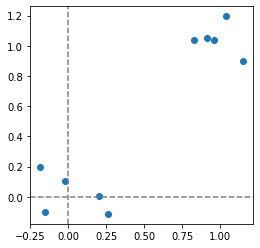

In [7]:
num_data = 10
data, true_c1, true_c2 = gen_gaussian_data(N=num_data, stddev=0.1)
np.random.shuffle(data)
plot_data(data)

In [8]:
# Implicitly assign last data point cluster 0 to remove symmetry in cluster labels
num_models = 2**(num_data - 1)

# Precompute the 2 cluster centers for each model
model_clusters = np.array([convert_bitstring_to_clusters(model, data) for model in range(num_models)])

# Use uniform distribution over all models for prior
prior = stats.uniform.pdf(np.zeros(num_models), loc=0, scale=num_models)

Bayesian inference, round 0


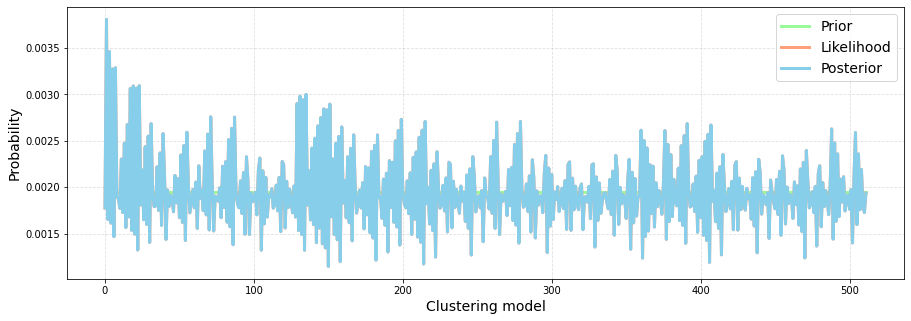

Bayesian inference, round 1


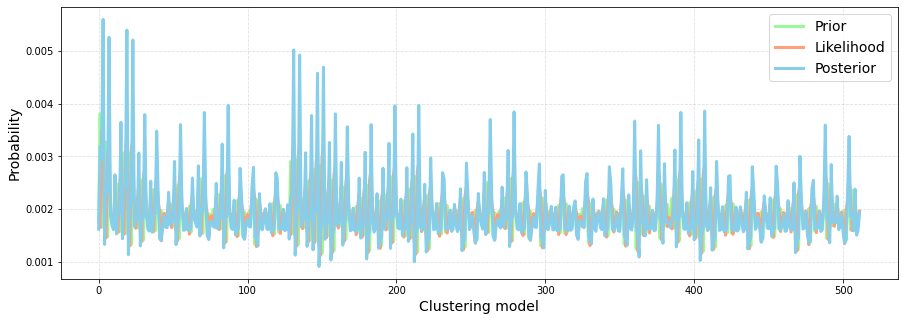

Bayesian inference, round 2


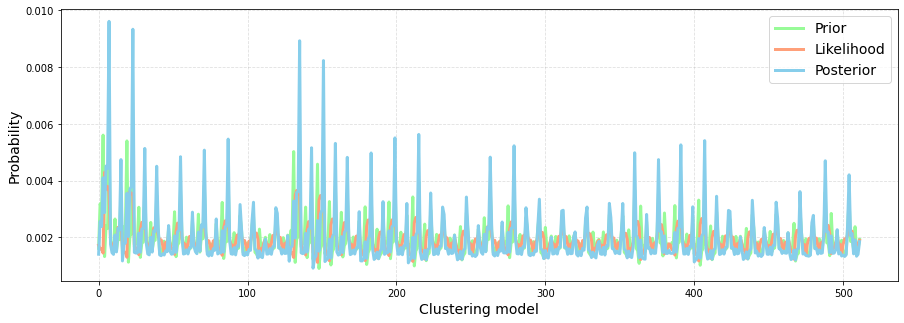

Bayesian inference, round 3


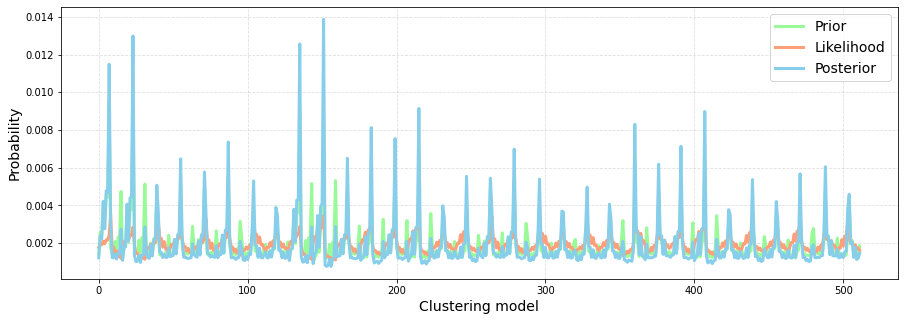

Bayesian inference, round 4


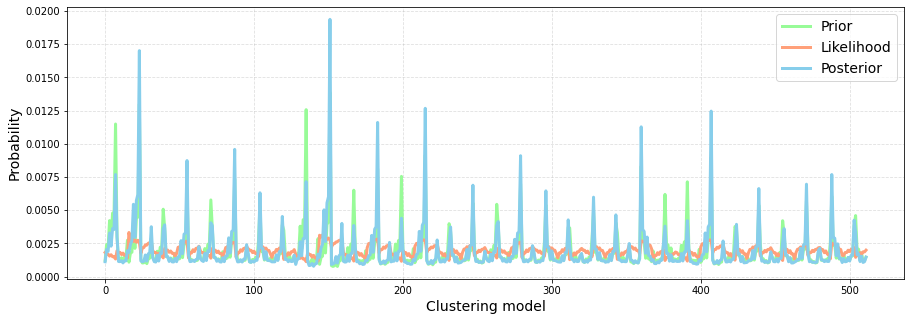

Bayesian inference, round 5


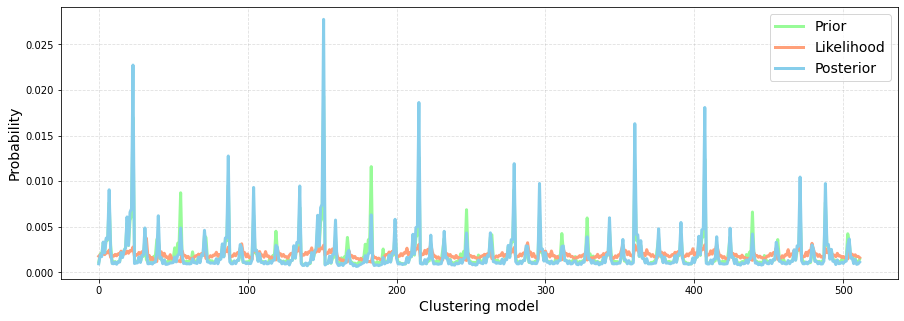

Bayesian inference, round 6


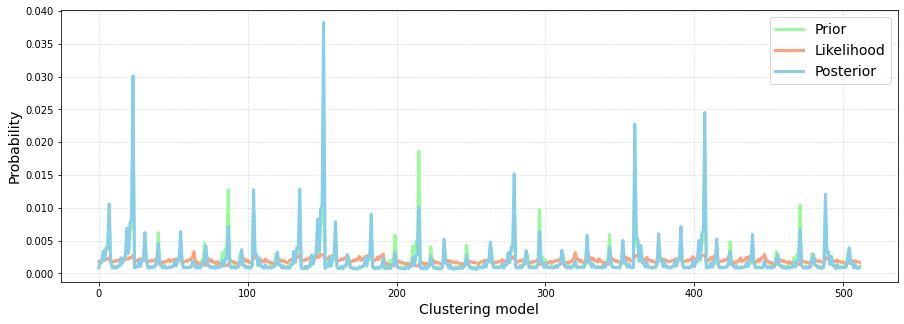

Bayesian inference, round 7


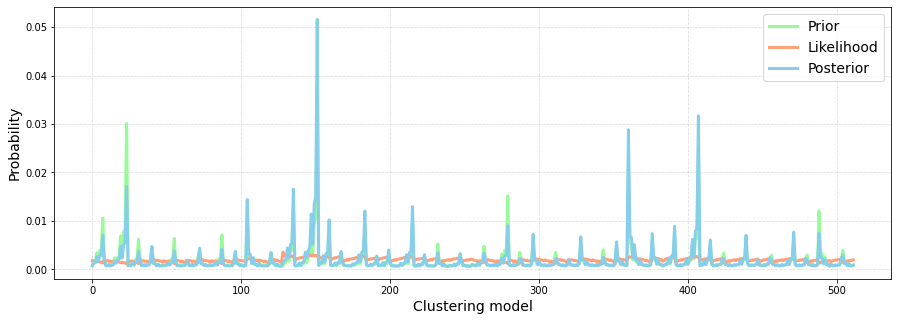

Bayesian inference, round 8


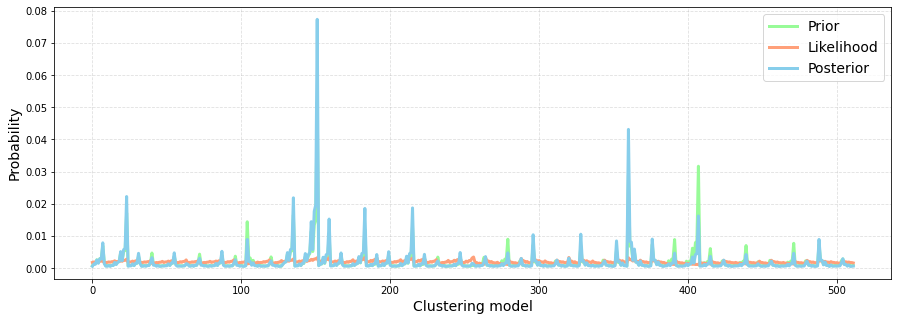

In [9]:
# Iteratively grab a new data point and use bayesian inference to update our distribution for which model is best
for rnd in range(num_data - 1):
    print(f'Bayesian inference, round {rnd}')
    curr_clusters = get_clusters_for_data(rnd, model_clusters)
    likelihood = calculate_likelihood(data[rnd], curr_clusters)
    posterior = prior * likelihood
    posterior /= np.sum(posterior)
    plot_round(prior, likelihood, posterior, range(num_models))
    prior = posterior
model = np.argmax(prior)

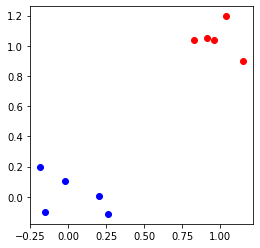

In [10]:
plot_cluster(data, model)

Calculating likelihood based off a growing coreset-of-sorts each iteration

In [11]:
def calculate_likelihood_coreset(x: np.ndarray, model_clusters: np.ndarray) -> np.ndarray:
    total_dist = 0.0
    for i in range(len(x)):
        total_dist += np.linalg.norm(x[i] - model_clusters[i], axis=1)
    likelihood = np.exp(-total_dist)
    return likelihood / np.sum(likelihood)

Bayesian inference, round 0


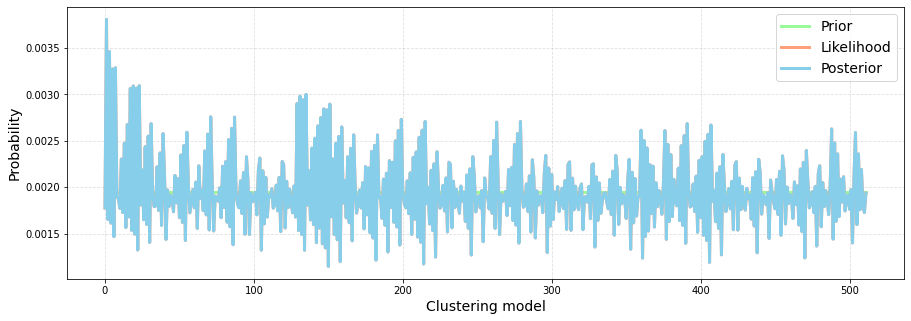

Bayesian inference, round 1


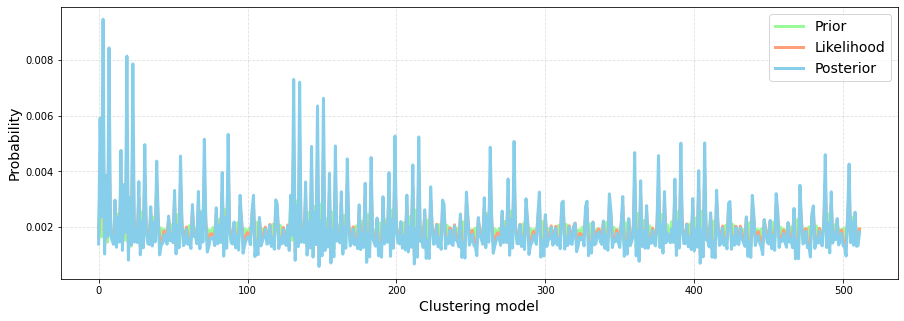

Bayesian inference, round 2


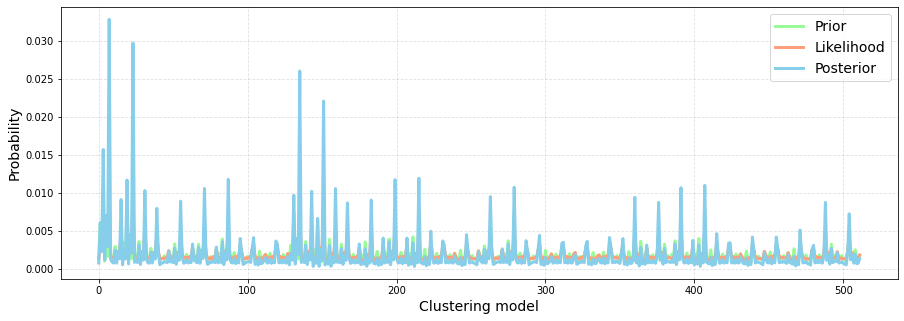

Bayesian inference, round 3


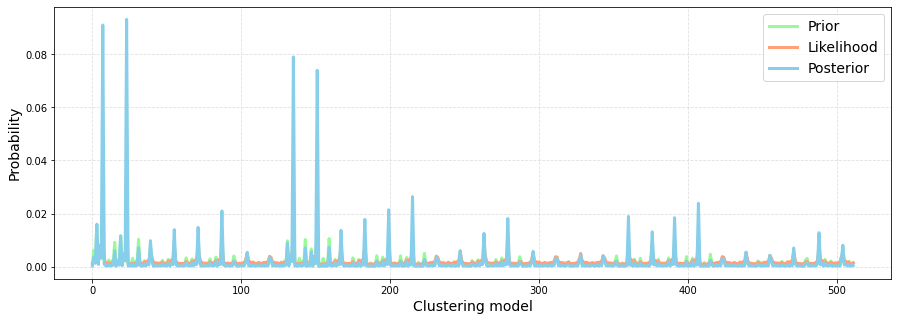

Bayesian inference, round 4


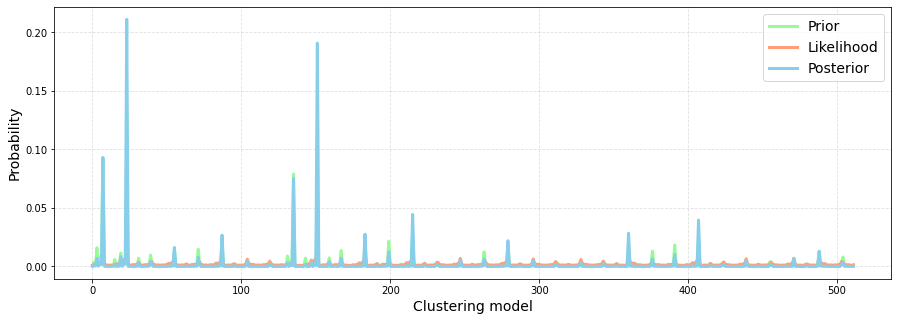

Bayesian inference, round 5


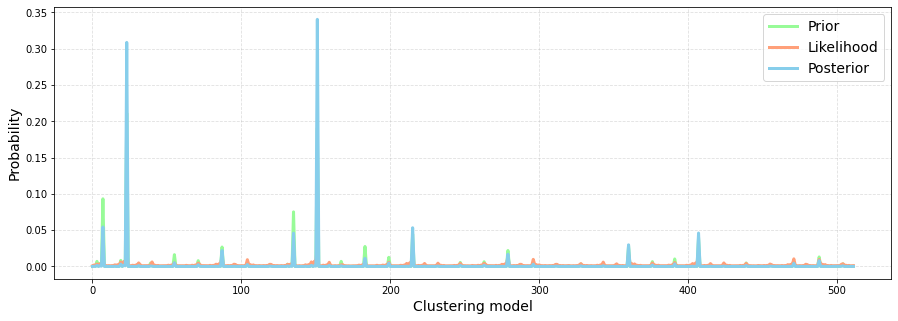

Bayesian inference, round 6


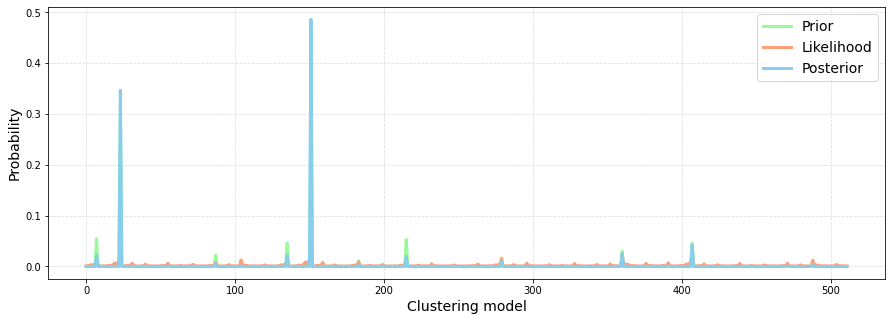

Bayesian inference, round 7


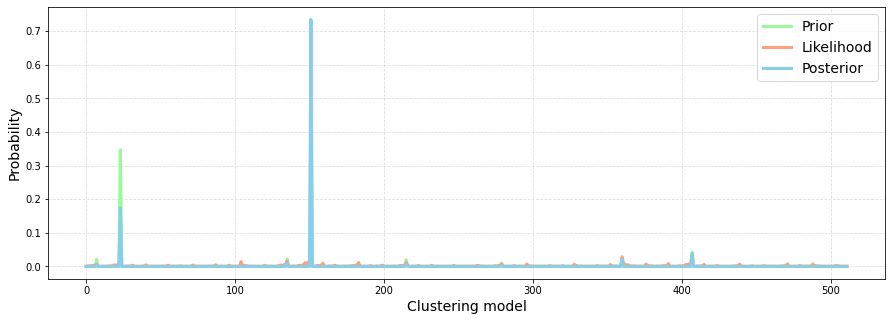

Bayesian inference, round 8


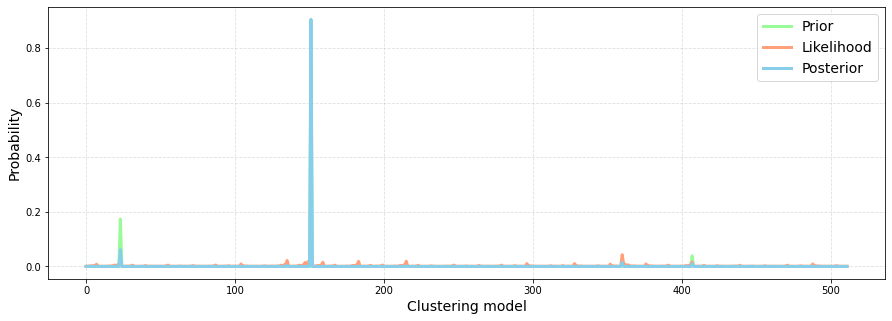

In [12]:
# Iteratively grab a new data point and use bayesian inference to update our distribution for which model is best
prior = stats.uniform.pdf(np.zeros(num_models), loc=0, scale=num_models)
coreset = []
for rnd in range(num_data - 1):
    print(f'Bayesian inference, round {rnd}')
    coreset.append(data[rnd])
    curr_clusters = np.array([get_clusters_for_data(i, model_clusters) for i in range(rnd + 1)])
    likelihood = calculate_likelihood_coreset(coreset, curr_clusters)
    posterior = prior * likelihood
    posterior /= np.sum(posterior)
    plot_round(prior, likelihood, posterior, range(num_models))
    prior = posterior
model = np.argmax(prior)

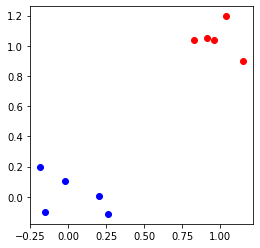

In [13]:
plot_cluster(data, model)

## Voronoi Diagrams to scale number models from $O(2^N)$ to $O(n^4)$

In [14]:
from scipy.spatial import Voronoi, voronoi_plot_2d

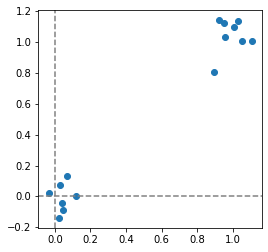

In [101]:
num_data = 15
data, true_c1, true_c2 = gen_gaussian_data(N=num_data, stddev=0.1)
np.random.shuffle(data)
plot_data(data)

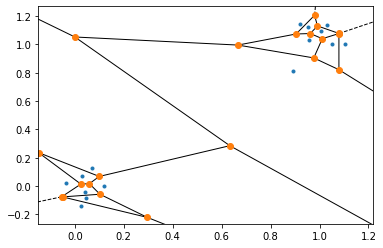

In [102]:
vor = Voronoi(data)
fig = voronoi_plot_2d(vor)
plt.show()

In [103]:
def generate_neighbors(vor: Voronoi) -> dict:
    neighbor_dict = {region: [] for region in range(len(vor.points))}
    for ridge in vor.ridge_points:
        neighbor_dict[ridge[0]].append(ridge[1])
        neighbor_dict[ridge[1]].append(ridge[0])
    return neighbor_dict

def generate_models(vor: Voronoi, neighbors_dict: dict) -> list:
    #TODO: this is super inefficient. probably good idea to optimize it 
    models = []
    def visit_model(model: set):
        if model in models:
            return
        models.append(model)
        for region in model:
            for neighbor in neighbors_dict[region]:
                new_model = model.copy()
                new_model.add(neighbor)
                visit_model(new_model)
    init_model = {0}
    visit_model(init_model)
    return models

def get_model_clusters(vor: Voronoi, model: set) -> np.ndarray:
    cluster_0 = np.array([0.0, 0.0])
    cluster_1 = np.array([0.0, 0.0])
    for point in range(len(vor.points)):
        if point in model:
            cluster_0 += vor.points[point]
        else: 
            cluster_1 += vor.points[point]
    if len(model) > 0:
        cluster_0 /= len(model)
    if len(vor.points) > len(model):
        cluster_1 /= len(vor.points) - len(model)
    return np.array([cluster_0, cluster_1])

def get_clusters_for_curr(curr: int, models: list, model_clusters: np.ndarray) -> np.ndarray:
    return np.array([model_clusters[i][0] if curr in models[i] else model_clusters[i][1] for i in range(len(models))])

In [104]:
neighbors = generate_neighbors(vor)
models = generate_models(vor, neighbors)
model_clusters = np.array([get_model_clusters(vor, model) for model in models])


Bayesian inference, round 0


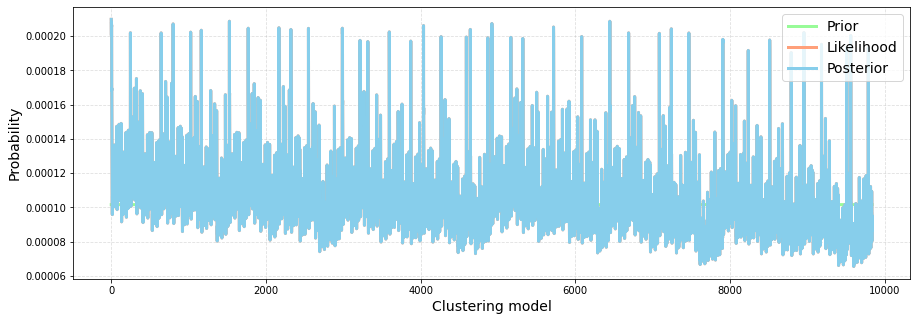

Bayesian inference, round 1


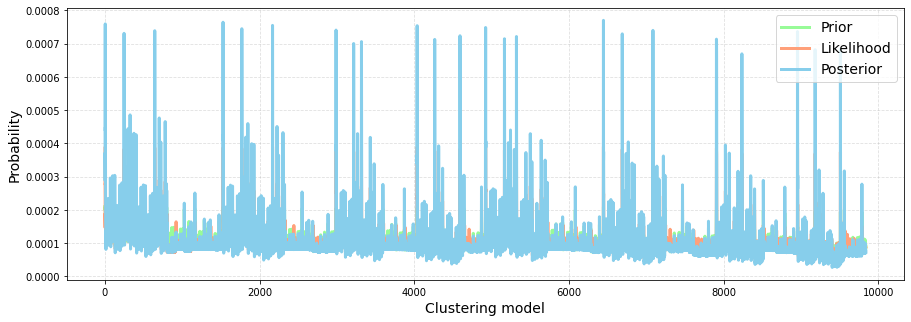

Bayesian inference, round 2


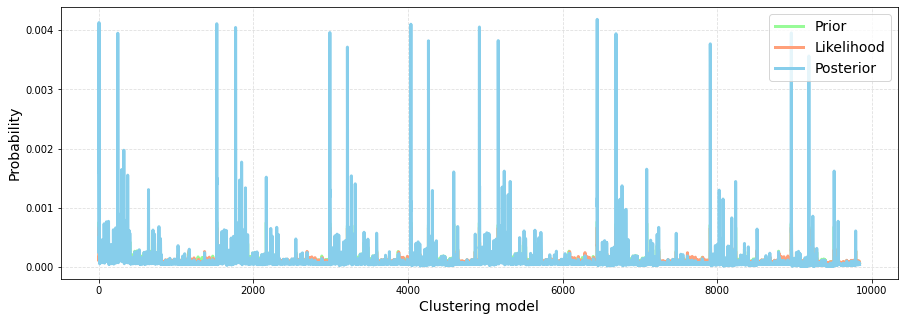

Bayesian inference, round 3


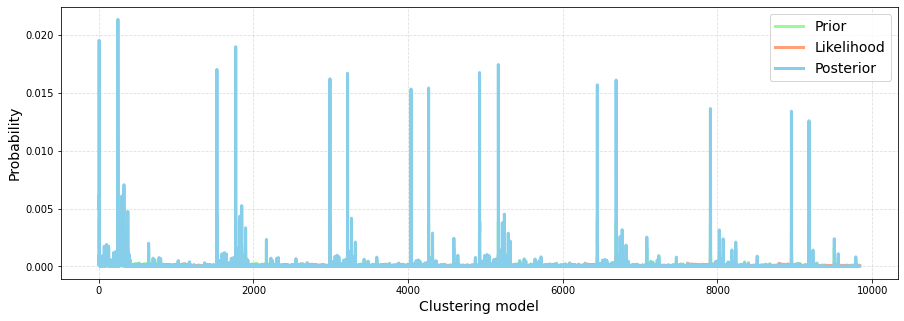

Bayesian inference, round 4


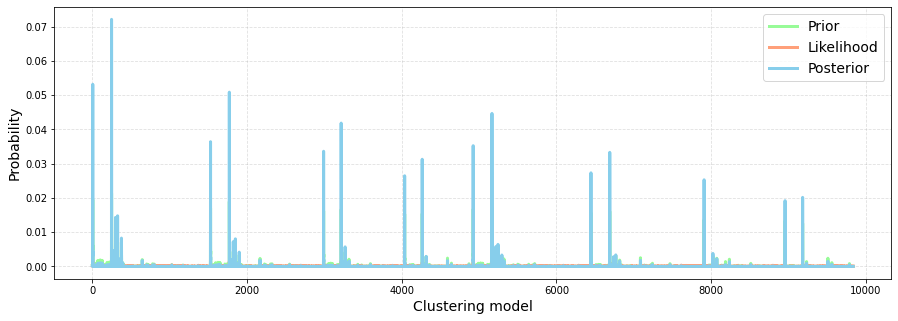

Bayesian inference, round 5


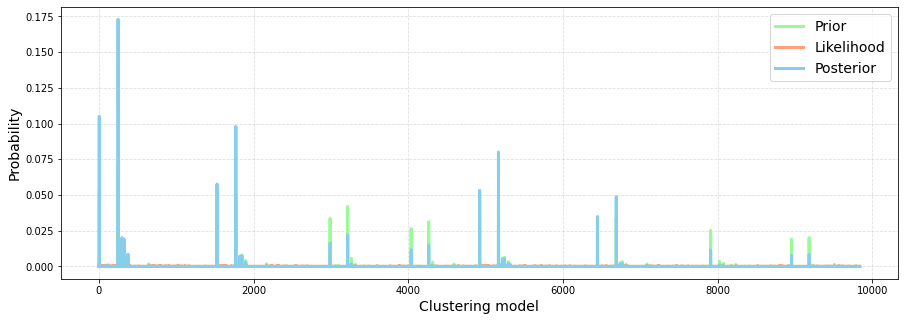

Bayesian inference, round 6


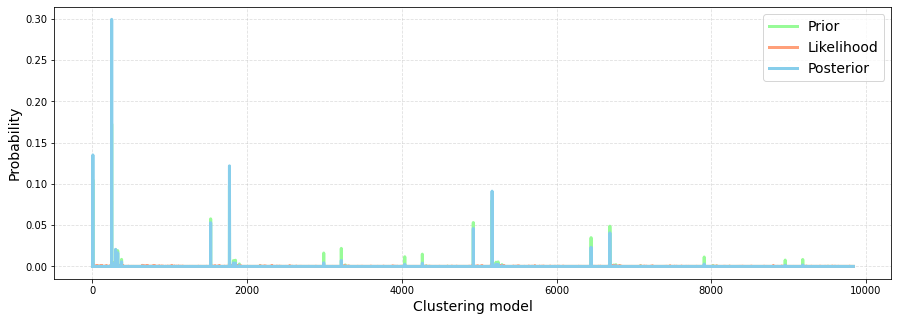

Bayesian inference, round 7


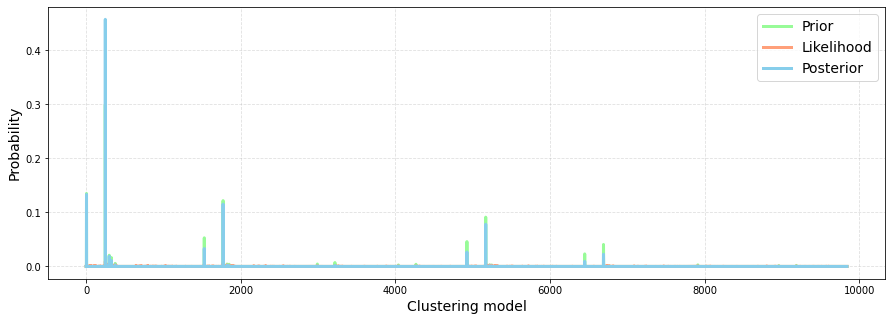

Bayesian inference, round 8


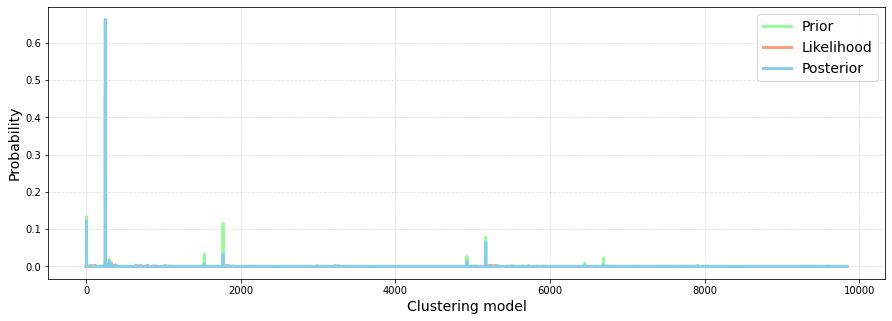

Bayesian inference, round 9


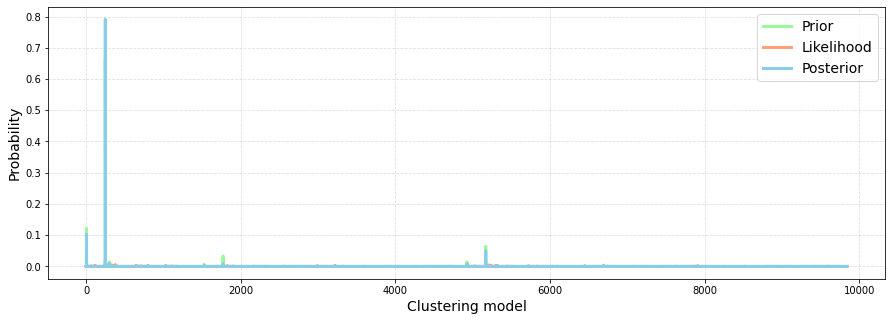

Bayesian inference, round 10


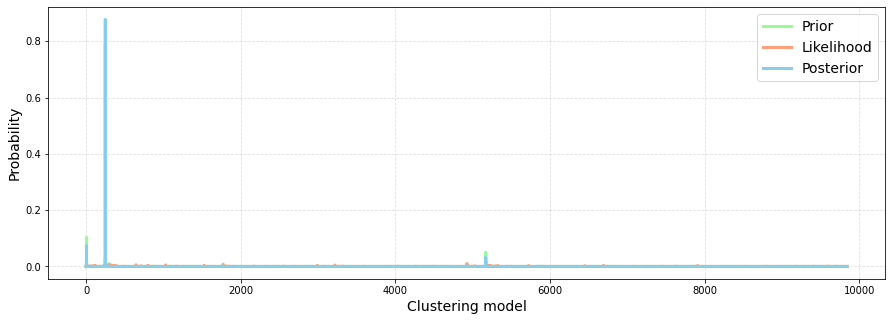

Bayesian inference, round 11


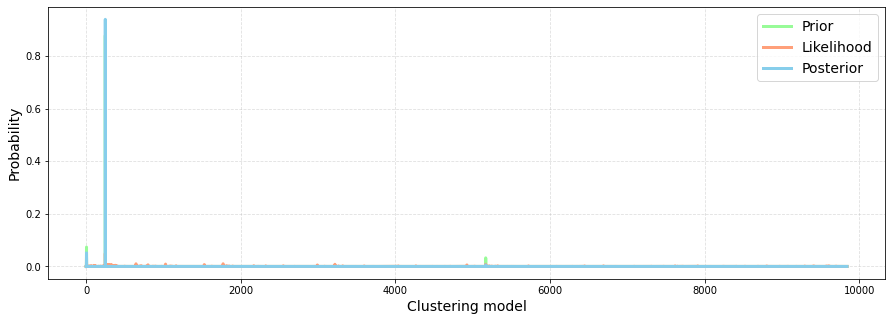

Bayesian inference, round 12


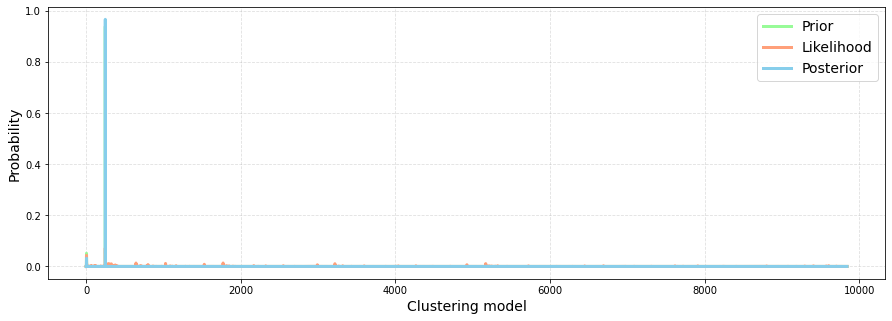

Bayesian inference, round 13


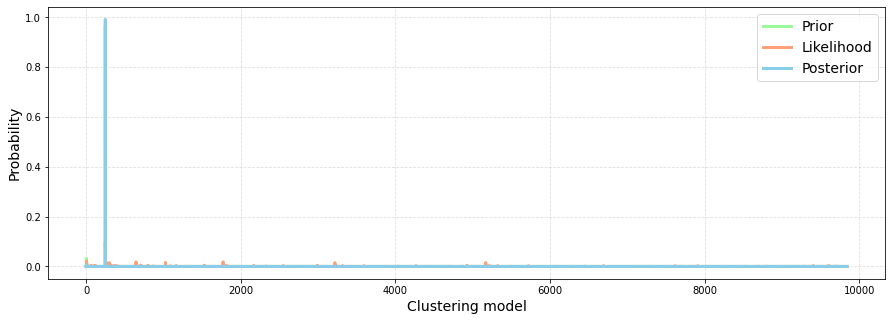

In [105]:
# Iteratively grab a new data point and use bayesian inference to update our distribution for which model is best
prior = stats.uniform.pdf(np.zeros(len(models)), loc=0, scale=len(models))
coreset = []
for rnd in range(num_data - 1):
    print(f'Bayesian inference, round {rnd}')
    coreset.append(data[rnd])
    curr_clusters = np.array([get_clusters_for_curr(i, models, model_clusters) for i in range(rnd + 1)])
    likelihood = calculate_likelihood_coreset(coreset, curr_clusters)
    posterior = prior * likelihood
    posterior /= np.sum(posterior)
    plot_round(prior, likelihood, posterior, range(len(models)))
    prior = posterior
model = np.argmax(prior)

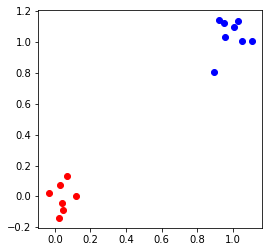

In [106]:
plot_cluster_voronoi(vor, models[model])